<a href="https://colab.research.google.com/github/TraanQuang1509/ImageProcessing/blob/master/Generation_of_Image_Caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys 
sys.path.insert(0,'/content/drive/MyDrive/Project_AI')
%cd /content/drive/MyDrive/Project_AI
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project_AI


'/content/drive/MyDrive/Project_AI'

In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.utils import load_img
from keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [ ]:
# Load the document file into memory
def load_doc(filename):
    # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all images with their captions
def img_capt(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            descp = img_caption.split()
            #uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            #remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            #remove hanging 's and a
            descp = [wrd for wrd in descp if(len(wrd)>1)]
            #remove words containing numbers with them
            descp = [wrd for wrd in descp if(wrd.isalpha())]
            #converting back to string
            img_caption = ' '.join(descp)
            captions[img][i]= img_caption
    return captions

def txt_vocab(descriptions):
    # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

#To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
            data = "\n".join(lines)
            file = open(filename,"w")
            file.write(data)
            file.close()
# Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "/content/drive/MyDrive/Project_AI/data"
dataset_images = "/content/drive/MyDrive/Project_AI/data/Flicker8k_Dataset"
#to prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")

In [ ]:
from keras.utils import plot_model
#Model pre-train Xception
cnn_model = Xception(include_top=False, pooling='avg')

## Xception was trained on an Imagenet dataset with 1000 different classes to classify the images

##The xception model takes 299x299x3 image size as input so we need to delete the last classification layer and extract out the 2048 feature vectors

In [ ]:
print(cnn_model.summary())
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

In [ ]:
def extract_features(dirc):
    model = Xception( include_top=False, pooling='avg' )
    features = {}
    for pic in tqdm(os.listdir(dirc)):
        file = dirc + "/" + pic
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        features[pic] = feature
    return features
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))
#to directly load the features from the pickle file.
features = load(open("features.p","rb"))

## **Loading dataset for model training**

In [ ]:

#load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos
def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
              descriptions[image] = []
              desc = ' ' + " ".join(image_caption) + ' '
              descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)


In [ ]:
dataset_text = "/content/drive/MyDrive/Project_AI/data"
dataset_images = "/content/drive/MyDrive/Project_AI/data/Flicker8k_Dataset"
# Load the document file into memory
def load_doc(filename):
    # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
#load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos
def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
              descriptions[image] = []
              desc = ' ' + " ".join(image_caption) + ' '
              descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)
vocab_size = 3846
max_length = 32

In [ ]:
#convert dictionary to clear list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer    
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size) #The size of our vocabulary is 7577 words.
#calculate maximum length of descriptions to decide the model structure parameters.
# def max_length(descriptions):
#     desc_list = dict_to_list(descriptions)
#     return max(len(d.split()) for d in desc_list)
# max_length = max_length(descriptions)
# print(max_length) #Max_length of description is 32
max_length = 32

3846


In [ ]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
        yield [[inp_image, inp_seq], op_word]
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
    # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
    # divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
    # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)
#To check the shape of the input and output for your model
features = load(open("features.p","rb"))
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((4, 2048), (4, 32), (4, 3846))

In [ ]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# creating a directory named models to save our models
# os.mkdir("models")
for i in range(epochs):
   generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
   model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
   model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 3846
Description Length:  32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 256)      984576      ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_3[0][0]']  

KeyboardInterrupt: ignored

1/1 [==============================] - 1s 962ms/step
nn
start stands stands near golden walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls walls


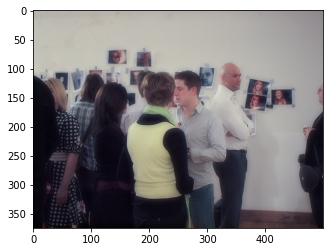

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# import argparse
# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
# img_path = args['image']
import random
dataset_images = "/content/drive/MyDrive/Project_AI/data/Flicker8k_Dataset"
image = random.choice(os.listdir(dataset_images))
img_path = dataset_images + "/" + image
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    pre_word = ""
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)

        
        if word is None:
            break
        # if pre_word != word:
        #     in_text += ' ' + word
        in_text += ' ' + word
        # else: 
        #     in_text = in_text
        # pre_word = word
        if word == 'end':
            break
    return in_text
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)